# Importing ONNX models to Tensorflow

We'll show how you can use ONNX-Tensorflow to import ONNX models into Tensorflow, and use the imported model for inference.

## Step 1: Installation

First install ONNX, following the instructions on the ONNX repo.

Then, install the ONNX-Tensorflow package:

  $ pip install onnx-tf
  
If you don't already have it installed, the above command will also install Tensorflow.

## Step 2: Prepare an ONNX model to import

In this example, we will demonstrate importing a Super Resolution model, designed to increase the spatial resolution of images. The model was built and trained with PyTorch, and exported into ONNX using Pytorch's ONNX export API. More details about the model design are available in Pytorch's example.

## Step 3: Import the ONNX model into Tensorflow

Now that we have an ONNX model file ready, let's import it into Tensorflow using ONNX-Tensorflow's import API.

In [1]:
import onnx
from onnx_tf.backend import prepare
model = onnx.load('assets/super_resolution.onnx')
tf_rep = prepare(model)

Now we have `tf_rep`, which is a python class containing three members: `predict_net`, `input_dict`, and `uninitialized`.

In [2]:
print(tf_rep.predict_net)
print('-----')
print(tf_rep.input_dict)
print('-----')
print(tf_rep.uninitialized)

-----
{'2': <tf.Tensor 'Const:0' shape=(64, 1, 5, 5) dtype=float32>, '3': <tf.Tensor 'Const_1:0' shape=(64,) dtype=float32>, '4': <tf.Tensor 'Const_2:0' shape=(64, 64, 3, 3) dtype=float32>, '5': <tf.Tensor 'Const_3:0' shape=(64,) dtype=float32>, '6': <tf.Tensor 'Const_4:0' shape=(32, 64, 3, 3) dtype=float32>, '7': <tf.Tensor 'Const_5:0' shape=(32,) dtype=float32>, '8': <tf.Tensor 'Const_6:0' shape=(9, 32, 3, 3) dtype=float32>, '9': <tf.Tensor 'Const_7:0' shape=(9,) dtype=float32>, '1': <tf.Tensor '1:0' shape=(1, 1, 224, 224) dtype=float32>}
-----
['1']


## Step 4: Prepare input for inference

Next, we will prepare an input image for inference. The steps below downloads an example image, resizes it to the model's expected input shape, and finally converts it into a numpy array.

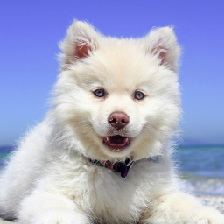

In [3]:
import numpy as np
from PIL import Image
img = Image.open('assets/super-res-input.jpg').resize((224, 224))
display(img) # show the image
img_ycbcr = img.convert("YCbCr")
img_y, img_cb, img_cr = img_ycbcr.split()
doggy_y = np.asarray(img_y, dtype=np.float32)[np.newaxis, np.newaxis, :, :]

## Step 5: Run the network!


In [4]:
big_doggy = tf_rep.run(doggy_y)._0
print(big_doggy.shape)

(1, 1, 672, 672)


## Step 6: Examine the results

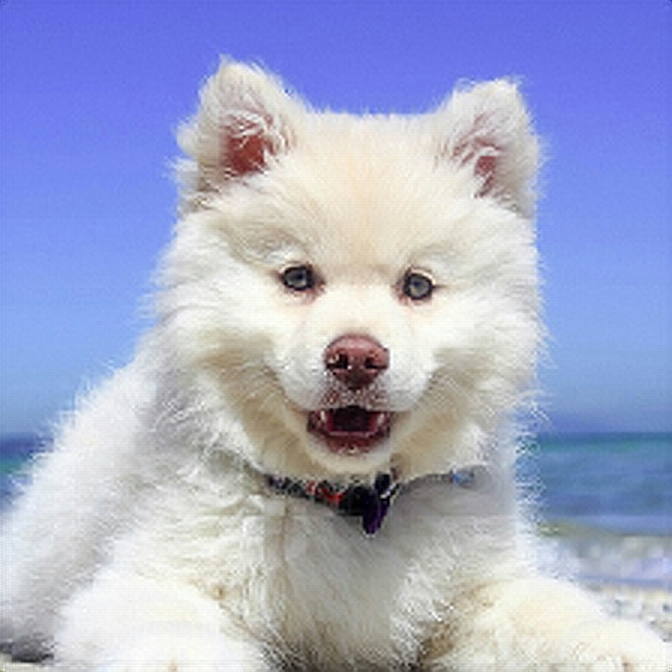

In [5]:
img_out_y = Image.fromarray(np.uint8(big_doggy[0, 0, :, :].clip(0, 255)), mode='L')
result_img = Image.merge("YCbCr", [
    img_out_y,
    img_cb.resize(img_out_y.size, Image.BICUBIC),
    img_cr.resize(img_out_y.size, Image.BICUBIC),
]).convert("RGB")
display(result_img)
result_img.save('output/super_res_output.jpg')